# License Plates Recognition

In [38]:
!pip install imutils

In [39]:
import os
from os import listdir
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import resize
import imutils

In [40]:
def visualize(images,titles=None,suptitles=None,n=None):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i in range(len(images)):
        axes[i].imshow(images[i], cmap='gray')
        if titles != None:
            axes[i].set_title(titles[i])
        axes[i].axis("off")
    if suptitles != None:
        plt.suptitle(suptitles[n])
    plt.tight_layout()
    plt.show()

## 1. Extract Licence Plates images

In [41]:
frontal_plates_path = "Test/Test/Frontal/Frontal/"
lateral_plates_path = "Test/Test/Lateral/Lateral/"

frontal_plates = []
lateral_plates = []
all_plates = []

In [42]:
for image in os.listdir(frontal_plates_path):
    if (image.endswith(".png") or image.endswith(".jpg") or image.endswith(".jpeg")):
        image = cv2.imread(frontal_plates_path+image)
        frontal_plates.append(image)
        all_plates.append(image)

for image in os.listdir(lateral_plates_path):
    if (image.endswith(".png") or image.endswith(".jpg") or image.endswith(".jpeg")):
        image = cv2.imread(lateral_plates_path+image)
        lateral_plates.append(image)
        all_plates.append(image)

In [43]:
# Show some examples of plates



In [44]:
image_path = "Test/Test/Lateral/Lateral/8727JTC.jpg"
image = image = cv2.imread(image_path)
image = imutils.resize(image, width=640)

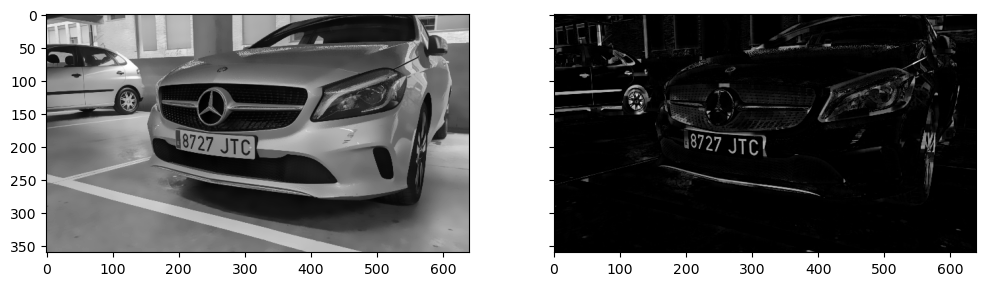

In [45]:
# To grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Bilateral filter to smooth
bilat = cv2.bilateralFilter(gray,15,17,17)
# Blackhat
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
blackhat = cv2.morphologyEx(bilat, cv2.MORPH_BLACKHAT, kernel, iterations=3)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(bilat, cmap= 'gray')
ax2.imshow(blackhat, cmap= 'gray')

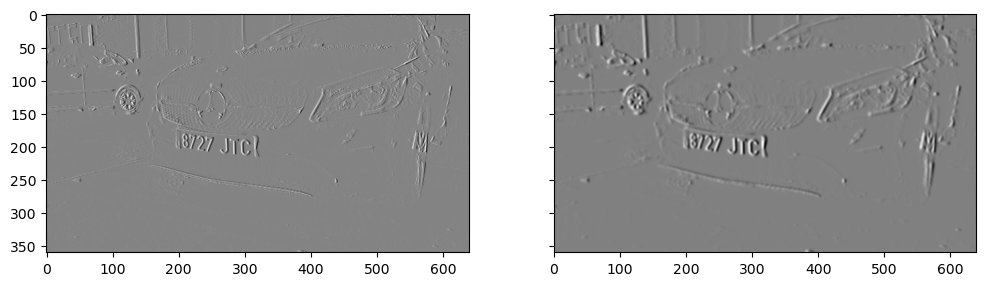

In [46]:
# Sobelx: detect borders
sobelx = cv2.Sobel(blackhat,cv2.CV_64F,dx=1, dy=0, ksize=1)
# Gaussian blur: Smooth noise and delete borders we don't need
smooth = cv2.GaussianBlur(sobelx, (7,7),0)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(sobelx, cmap= 'gray')
ax2.imshow(smooth, cmap= 'gray')

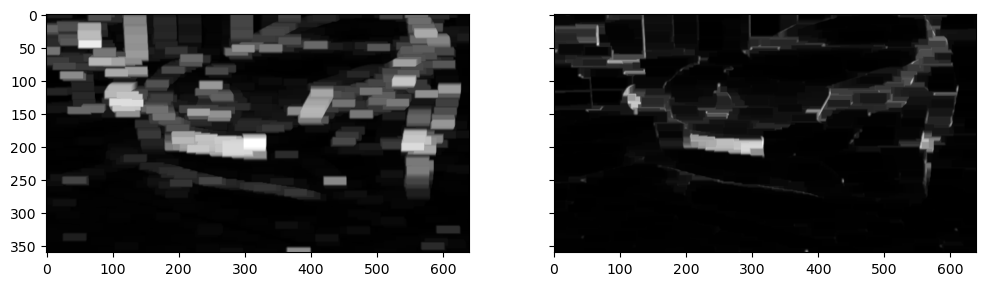

In [47]:
# Closing (but separated to see evolution - closing = dilation then erosion)

filter_size = (17,5)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filter_size)

# Dilation
dilation = cv2.dilate(smooth, rect_kernel, iterations=2)

# Erode
erosion = cv2.erode(dilation, rect_kernel, iterations=2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(dilation, cmap= 'gray')
ax2.imshow(erosion, cmap= 'gray')

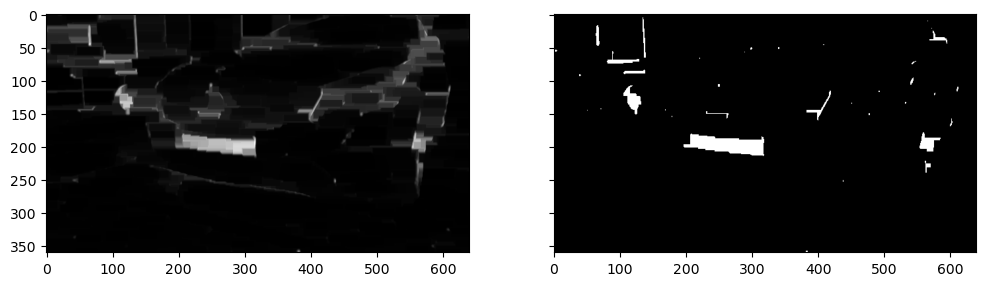

In [48]:
# Threshold
threshold_value = (0.40)*np.max(erosion)
_, bin_threshold = cv2.threshold(erosion, threshold_value, 255, cv2.THRESH_BINARY)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(erosion, cmap= 'gray')
ax2.imshow(bin_threshold, cmap= 'gray')

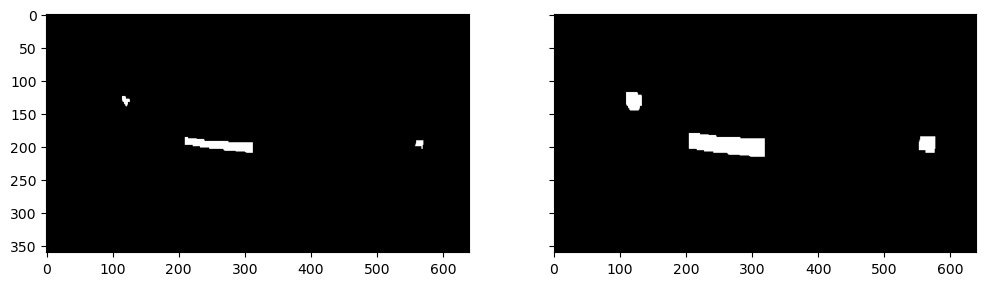

In [49]:
# Erosion and dilation again
erosion2 = cv2.erode(bin_threshold,kernel,iterations=4)
dilation2 = cv2.dilate(erosion2,kernel,iterations=6)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(erosion2, cmap= 'gray')
ax2.imshow(dilation2, cmap= 'gray')


In [50]:
def delete_borders(image):
    """
    Function to delete borders by iterating white pixels 
    touching borders and doing Floodfill
    """
    out_image = image.copy()
    h, w = image.shape[:2]
    for row in range(h):
        if out_image[row, 0] == 255:
            cv2.floodFill(out_image, None, (0, row), 0)
        if out_image[row, w - 1] == 255:
            cv2.floodFill(out_image, None, (w - 1, row), 0)
    for col in range(w):
        if out_image[0, col] == 255:
            cv2.floodFill(out_image, None, (col, 0), 0)
        if out_image[h - 1, col] == 255:
            cv2.floodFill(out_image, None, (col, h - 1), 0)
    return out_image

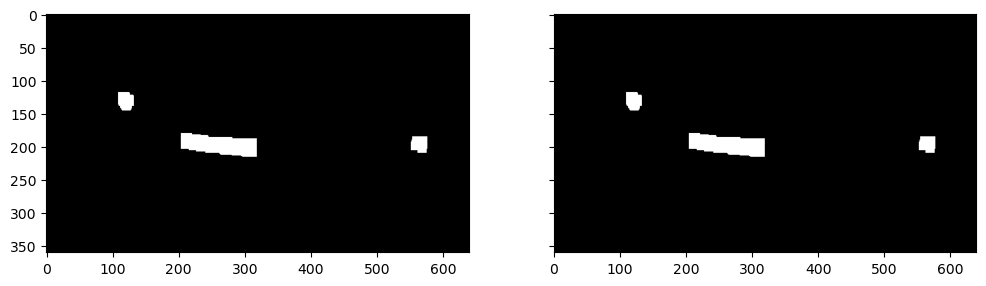

In [51]:
# Avoid erros because of type of image
processed_image = dilation2.astype(np.uint8)
# Delete borders
no_borders = delete_borders(processed_image)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(processed_image, cmap= 'gray')
ax2.imshow(no_borders, cmap= 'gray')

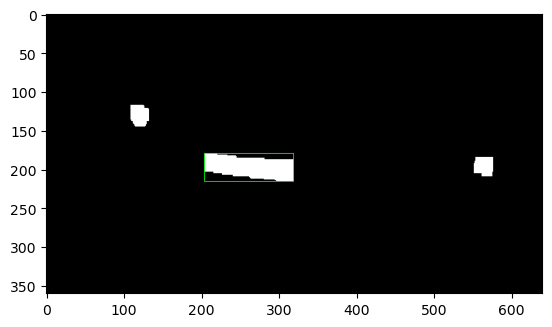

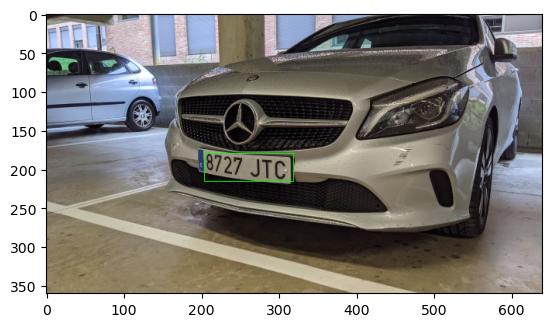

In [55]:
contours30, _ = cv2.findContours(no_borders, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find image countours
largest_contour30 = max(contours30, key=cv2.contourArea) #find biggest blob according to area
x, y, w, h = cv2.boundingRect(largest_contour30) #coordinates x and y, and width and height

output_image30 = cv2.cvtColor(no_borders, cv2.COLOR_GRAY2BGR)  #convert to BGR for color display
cv2.rectangle(output_image30, (x, y), (x + w, y + h), (0, 255, 0), 1)  #create a green rectangle

#display the results
plt.imshow(output_image30)
plt.show()


im_copy30 = image.copy() #create a copy so the original image doesnt get affected
cv2.rectangle(im_copy30, (x, y), (x + w, y + h), (0, 255, 0), 1)  #do green rectangle

#show the result
plt.imshow(cv2.cvtColor(im_copy30, cv2.COLOR_BGR2RGB))  #convert BGR to RGB for display purposes
plt.show()

In [53]:
def find_plate(image):
    contours, _

SyntaxError: expected ':' (2489203744.py, line 1)